In [1]:
from pandas_datareader import data as datareader
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import timedelta
from datetime import datetime

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Data reading

In [3]:
data = pd.read_csv('aapl_dataset.csv', index_col = 'Date')

In [4]:
data = data.dropna()

In [5]:
data.tail()

,high,low,open,close,volume,adj close,feat_RSI_close,feat_OBV_volume,feat_ATR_close,feat_HT_DCPERIOD_close,feat_HT_DCPHASE_close,feat_FUNDAMENTAL1_CHG,feat_FUNDAMENTAL2_CHG,feat_K10_FILING,feat_SENTIMENT_UP,feat_DIVIDEND
Date,,,,,,,,,,,,,,,,
2019-12-24,284.890015,282.920013,284.690002,284.269989,12119700.0,283.596924,74.436585,2.224292e+10,3.913542,28.454955,150.076370,-0.337975,0.541358,3,0,-0.982111
2019-12-26,289.980011,284.700012,284.820007,289.910004,23280300.0,289.223602,78.678994,2.226620e+10,4.041862,28.079039,153.345130,-0.408145,0.929980,0,1,-2.587859
2019-12-27,293.970001,288.119995,291.119995,289.799988,36566500.0,289.113831,78.405656,2.222964e+10,4.171015,27.740405,156.893808,0.162783,0.732749,3,1,0.814541
2019-12-30,292.690002,285.220001,289.459991,291.519989,36028600.0,290.829773,79.598963,2.226566e+10,4.406657,27.553361,160.727817,-0.933116,0.980977,0,0,-1.696447
2019-12-31,293.679993,289.519989,289.929993,293.649994,25201400.0,292.954712,80.999258,2.229087e+10,4.389039,27.941882,164.208211,0.383039,0.336035,1,0,0.176790


# Data Preparation

In [6]:
from mlfinlab.features.fracdiff import frac_diff_ffd
from utils import get_meta_barier, getDailyVol

In [7]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint

In [8]:
adf = lambda s: adfuller(s, autolag='AIC')
p_val = lambda s: adfuller(s, autolag='AIC')[1]

In [9]:
adf(pd.DataFrame(data['close']))

(2.4738002715406058,
 0.9990409119702275,
 29,
 4938,
 {'1%': -3.4316749701517963,
  '5%': -2.862125491914587,
  '10%': -2.5670816583341},
 17198.616010838927)

In [10]:
adf(pd.DataFrame(data['close']).diff().dropna())

(-10.253755800048758,
 4.416004081500417e-18,
 32,
 4934,
 {'1%': -3.431676044866379,
  '5%': -2.8621259667150416,
  '10%': -2.567081911089371},
 17194.60784386485)

In [11]:
rangee = np.arange(0.1, 1.1, 0.1)
adfs, corrs = [], []
for d in rangee:
    ts = frac_diff_ffd(pd.DataFrame(data['close']), d, thresh=1e-4)
    adf_i = adf(ts.dropna())[0]
    len_diff = len(data['close']) - len(ts.dropna())
    corr_i = np.corrcoef(ts.dropna().values.flatten(), data['close'].values.flatten()[len_diff:])[0][1]
    
    adfs.append(adf_i)
    corrs.append(corr_i)

In [12]:
for i in range(len(adfs)):
    print('d =', round(rangee[i], 3), 
          'ADF =', round(adfs[i], 3), 
          'Corr =', round(corrs[i], 3), 
          'ADF 95% cutoff =', -2.86)

d = 0.1 ADF = 1.583 Corr = 0.998 ADF 95% cutoff = -2.86
d = 0.2 ADF = 0.982 Corr = 0.988 ADF 95% cutoff = -2.86
d = 0.3 ADF = 0.366 Corr = 0.966 ADF 95% cutoff = -2.86
d = 0.4 ADF = -0.369 Corr = 0.927 ADF 95% cutoff = -2.86
d = 0.5 ADF = -1.259 Corr = 0.861 ADF 95% cutoff = -2.86
d = 0.6 ADF = -2.258 Corr = 0.755 ADF 95% cutoff = -2.86
d = 0.7 ADF = -3.427 Corr = 0.606 ADF 95% cutoff = -2.86
d = 0.8 ADF = -4.736 Corr = 0.435 ADF 95% cutoff = -2.86
d = 0.9 ADF = -6.499 Corr = 0.269 ADF 95% cutoff = -2.86
d = 1.0 ADF = -10.254 Corr = 0.068 ADF 95% cutoff = -2.86


In [15]:
frac_diff_series = frac_diff_ffd(pd.DataFrame(data['close']), 0.7, thresh=1e-4)

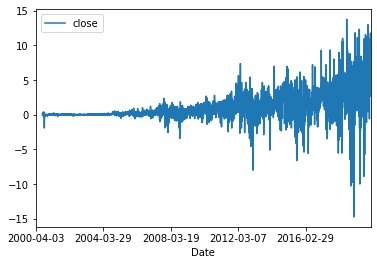

In [16]:
frac_diff_series.plot()

In [17]:
WINDOW = 14
HORIZON = 7

In [18]:
data['feat_mean_frac_close'] = frac_diff_series.rolling(WINDOW).mean()
data['feat_std_frac_close'] = frac_diff_series.rolling(WINDOW).std()
data['feat_skew_frac_close'] = frac_diff_series.rolling(WINDOW).skew()
data['feat_kurt_frac_close'] = frac_diff_series.rolling(WINDOW).kurt()
data['feat_autocorr_frac_close'] = frac_diff_series.rolling(WINDOW).apply(lambda x: x.autocorr(), raw=False)

In [19]:
t = '2015-01-01'
data_train = data[:t]
data_test = data[t:]

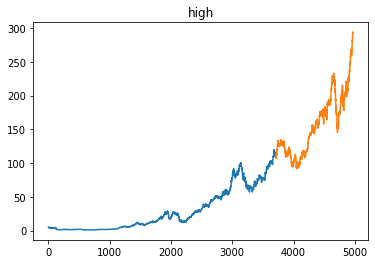

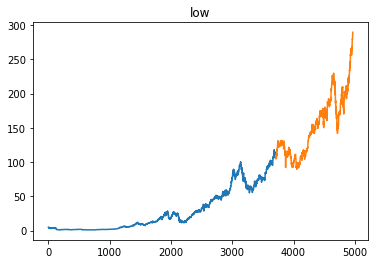

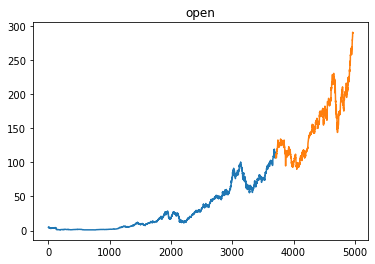

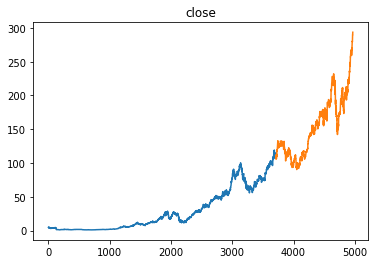

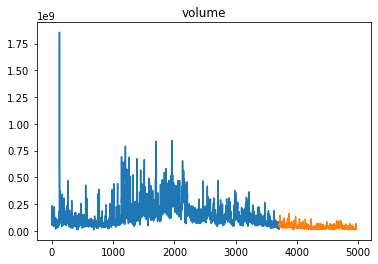

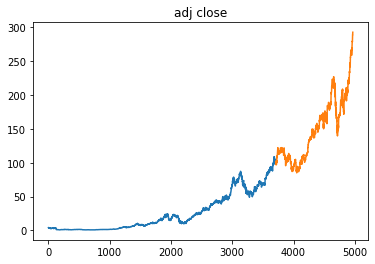

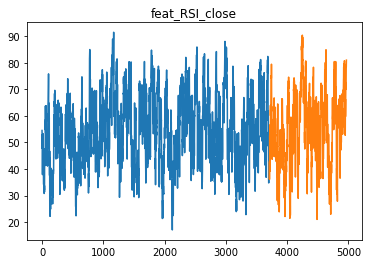

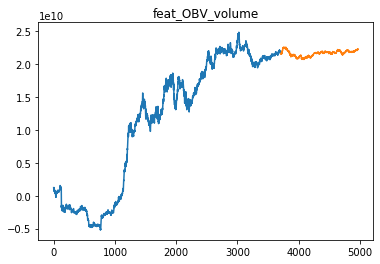

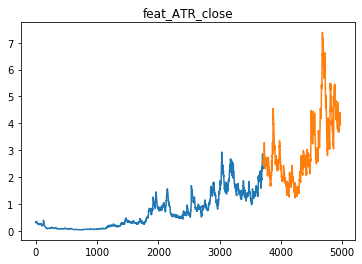

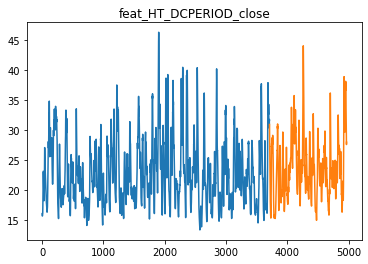

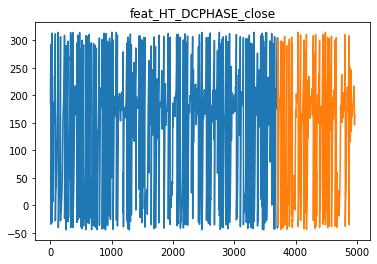

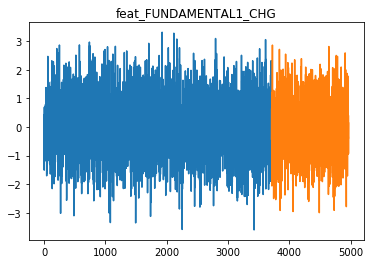

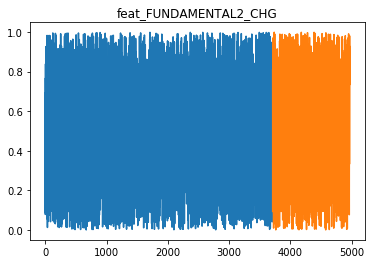

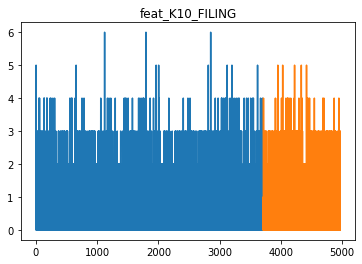

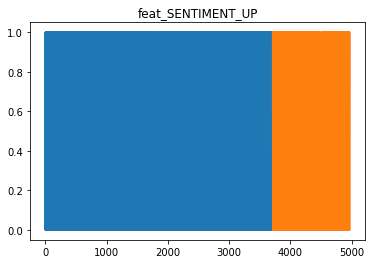

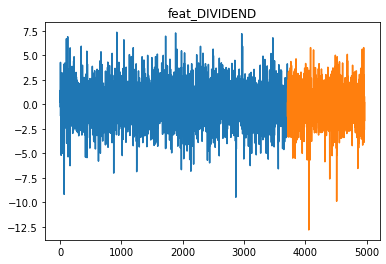

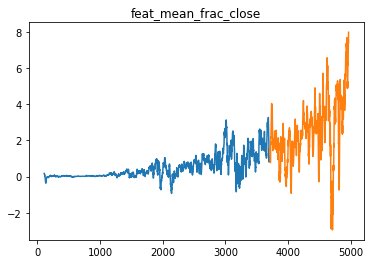

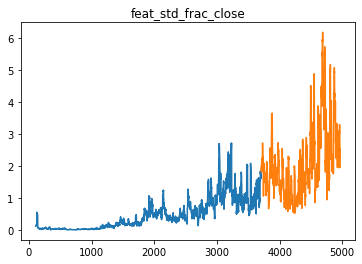

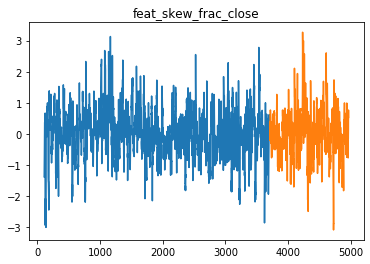

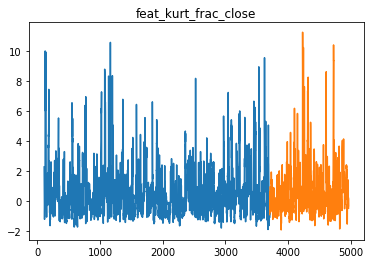

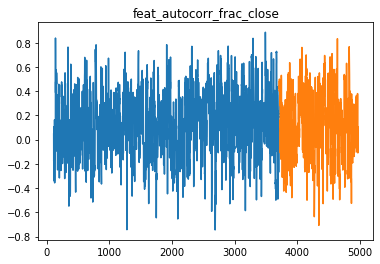

In [20]:
for column in data.columns:  
    plt.figure()
    plt.title(column)
    plt.plot(range(0, len(data_train)), data_train[column])
    plt.plot(range(len(data_train), len(data_train) + len(data_test)), data_test[column])
    plt.show()

# Dataset creation

In [21]:
FEATURE_COLUMNS = [d for d in data.columns if 'feat_' in d]

In [22]:
data.index = pd.to_datetime(data.index)

In [23]:
daily_vol = getDailyVol(data.close)

In [24]:
def create_dataset(data, daily_vol):
    
    TP = 0.01
    SL = - TP

    T, P, X, Y, Y2 = [], [], [], [], []

    for i in daily_vol.index:

        window = data.loc[i][FEATURE_COLUMNS].values

        if np.isnan(window).any():
            continue

        now = data.close[i]
        future_window = data.loc[i:i + timedelta(days=HORIZON)].close

        Ti = daily_vol.loc[i]

        min_ret_situation, take_action, timings = get_meta_barier(future_window, now, Ti, TP, SL, False)

        X.append(window)
        Y.append(min_ret_situation)
        Y2.append(take_action)
        
        T.append(timings)

        try:
            take_p_or_stop_loss = future_window[timings[np.argmax(min_ret_situation)][0]]
        except:
            take_p_or_stop_loss = future_window.values[-1]

        P.append(take_p_or_stop_loss - data.loc[i].close)
        
    X, Y, T, P = np.array(X), np.array(Y), np.array(T), np.array(P)

    return X, Y, T, P

In [25]:
from datetime import datetime

In [26]:
X, Y, T, P = create_dataset(data[:t], daily_vol[:t])

In [27]:
X_oos, Y_oos, T_oos, P_oos = create_dataset(data[t:], daily_vol[t:])

In [28]:
X_train, X_test, Y_train, Y_test, P_train, P_test = X, X_oos, Y[:, 0], Y_oos[:, 0], P, P_oos

In [29]:
X_train.shape, X_test.shape

((3601, 15), (1258, 15))

# Modeling

In [31]:
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import RidgeClassifier

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import r2_score, matthews_corrcoef, f1_score, mean_absolute_error
from sklearn.model_selection import train_test_split

In [34]:
mmcs, pred_prs = [], []
for n in range(50):
    clf = BaggingClassifier(RidgeClassifier())
#     clf = GradientBoostingClassifier()
    clf.fit(X_train, Y_train)
    pred = clf.predict(X_test)
    pred_pr = clf.predict_proba(X_test)
    mmcs.append(matthews_corrcoef(Y_test, pred))
    pred_prs.append(pred_pr)

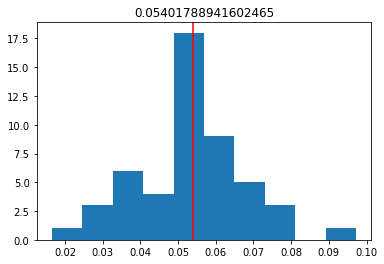

In [35]:
plt.figure()
plt.title(str(np.mean(mmcs)))
plt.hist(mmcs)
plt.axvline(np.mean(mmcs), color = 'red')
plt.show()

In [31]:
# GB, d = 1 : -0.043
# GB, d = 0.7 : -0.065

# BL, d = 1 : 0.015
# BL, d = 0.7 : 0.052

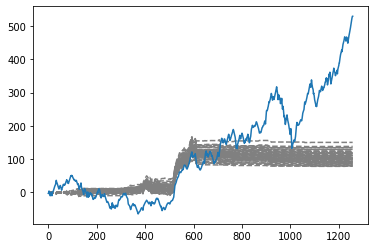

In [37]:
plt.figure()

for pred_pr in pred_prs:
#     signal = [-1.0 if p < 0.5 else 1.0 for p in pred_pr[:, 1]]
    signal = [-p if p < 0.5 else p for p in pred_pr[:, 1]]
    plt.plot((signal * P_test).cumsum(), color = 'grey', ls = '--')
plt.plot(P_test.cumsum())
plt.show()